In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target

c:\Users\William Costa\Documents\repositories\hands_on_machine_learning\.venv\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X.shape, y.shape

((70000, 784), (70000,))

'5'

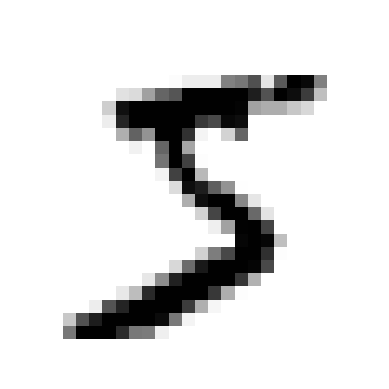

In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

plot_digit(X[0])
y[0]

In [4]:
# We don't do any split strategies because this dataset already contains this division
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

## Training a Binary Classifier

In [5]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train_5)
sgd_classifier.predict([X_test[0]]), y_test_5[0]

(array([False]), False)

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96365, 0.96335, 0.96775])

In [8]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train_5)
any(dummy_classifier.predict(X_train)), cross_val_score(dummy_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

(False, array([0.90965, 0.90965, 0.90965]))

**NOTE:** Since data is skewed (only 10% is 5) we have a baseline of 90% accuracy just by saying that it is not a 5

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_predict = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_predict)
cm, y_train_predict.shape

(array([[53428,  1151],
        [ 1110,  4311]], dtype=int64),
 (60000,))

In [10]:
import numpy as np
precision = cm[0, 0] / np.sum(cm[:, 0])
recall = cm[0, 0] / np.sum(cm[0])
precision, recall

(0.9796472184531886, 0.9789113028820609)

In [11]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_predict), recall_score(y_train_5, y_train_predict)

(0.7892713291834493, 0.7952407304925291)

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7922447854451897

### The Precision/Recall Trade-off

It is very difficult to increase both precision and recall. After a certain threshold increasing one means decreasing the other one.
Our task is then to identify the main goal of our algorithm:
- We increase precision in cases where it is more important to decrease False Positives. (Ex: When filtering videos for children we need to make sure no inapropriate video gets through even if some appropriate videos don't get through);
- We increase recall in cases where is it more important to decrease False Negatives. (Ex: When detecting cancer it is better to diagnose someone has having cancer when he doesn't have it then saying a person is healthy when they have cancer)
- In cases where we want to decrease both scenarios we can use the f1-scrore which tries to find the place where the precision and recall are at their highest before the tradeoff begins.

Conclusion:
- Maximizing Precision -> precision=100% recall=50%
- Maximizing Recall -> precision=75% recall=100%
- Maximmizing F1-score -> precision=80% recall=67%

In [22]:
y_scores = sgd_classifier.decision_function([X_train[0]])
y_scores


y_scores, (y_scores > 0), (y_scores > 3000) # Example of increasing recall while decreasing precision

(array([2860.04933267]), array([ True]), array([False]))

In [25]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

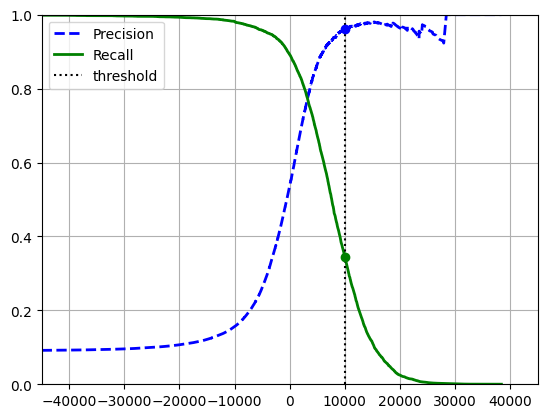

In [36]:
threshold = 10000
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')
plt.grid(True)
plt.legend()
plt.xlim(-45_000, 45_000)
plt.ylim(0, 1.0)

idx = (thresholds >= threshold).argmax() # The highest value in an boolean array is True. The argmax finds the first occurence of the highest value.
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')

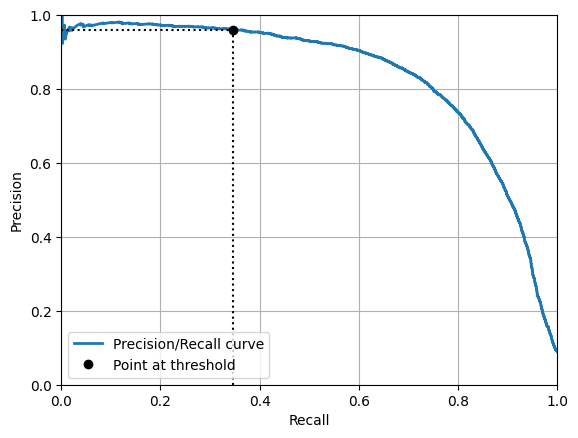

In [46]:
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')
plt.plot()
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.axis([0, 1, 0, 1])
plt.grid()

plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], 'k:')
plt.plot(recalls[idx], precisions[idx], 'ko', label='Point at threshold')

plt.legend()

In [47]:
# If you want to adjust threshold for 90% precision
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

6057.114004632907

In [49]:
# You can now use the following for prediction
y_train_predict_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_predict_90), recall_score(y_train_5, y_train_predict_90) 

(0.9001914137270988, 0.6072680317284633)

### ROC Curve

Used for binary classification. Plots recall against False Positive Rate (1 - True Negative Rate)

In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

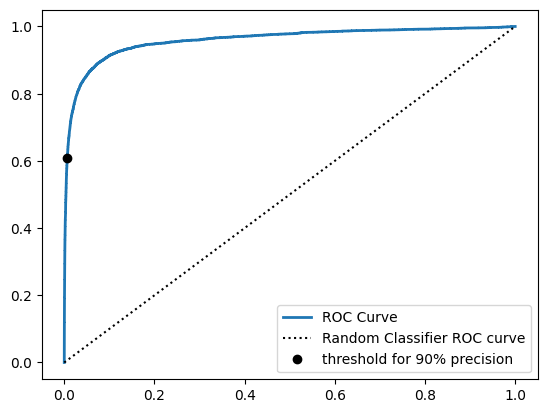

In [53]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0,1], [0,1], 'k:', label='Random Classifier ROC curve')
plt.plot([fpr_90], [tpr_90], 'ko', label='threshold for 90% precision')
plt.legend()

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9594711894378894

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state=42)

y_probability_a_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3, method='predict_proba')
y_probability_a_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [56]:
y_scores_forest = y_probability_a_forest[:, 1]

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

Text(0.5, 0, 'Recall')

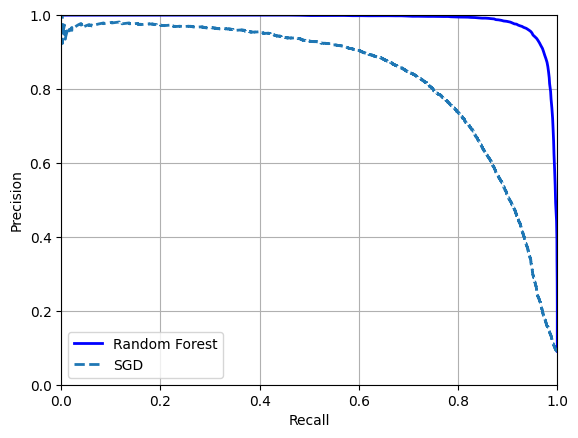

In [61]:
plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Random Forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.axis([0,1,0,1])
plt.grid()
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')

In [63]:
y_train_pred_forest = y_probability_a_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest), roc_auc_score(y_train_5, y_scores_forest) 

(0.9274509803921569, 0.9983436731328145)